<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  Demonstrate adversarial training using ART  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate adversarial training using ART on the MNIST dataset.


## Contents

1.	[Load prereqs and data](#prereqs)
2.  [Train and evaluate a baseline classifier](#classifier)
3.  [Adversarially train a robust classifier](#adv_training)
4.	[Evaluate the robust classifier](#evaluation)

<a id="prereqs"></a>
## 1. Load prereqs and data

In [1]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.defences.trainer import AdversarialTrainer

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')

<a id="classifier"></a>
## 2. Train and evaluate a baseline classifier

Load the classifier model:

In [3]:
path = get_file('mnist_cnn_original.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/p2nyzne9chcerid/mnist_cnn_original.h5?dl=1')
classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False)

In [4]:
classifier_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

Evaluate the classifier performance on the first 100 original test samples:

In [5]:
x_test_pred = np.argmax(classifier.predict(x_test[:100]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:100], axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(100-nb_correct_pred))

Original test data (first 100 images):
Correctly classified: 100
Incorrectly classified: 0


Generate some adversarial samples:

In [6]:
attacker = FastGradientMethod(classifier, eps=0.5)
x_test_adv = attacker.generate(x_test[:100])

And evaluate performance on those:

In [7]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:100], axis=1))

print("Adversarial test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(100-nb_correct_adv_pred))

Adversarial test data (first 100 images):
Correctly classified: 21
Incorrectly classified: 79


<a id="adv_training"></a>
## 3. Adversarially train a robust classifier

In [8]:
path = get_file('mnist_cnn_robust.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/yutsncaniiy5uy8/mnist_cnn_robust.h5?dl=1')
robust_classifier_model = load_model(path)
robust_classifier = KerasClassifier(clip_values=(min_, max_), model=robust_classifier_model, use_logits=False)

Note: the robust classifier has the same architecture as above, except the first dense layer has **1024** instead of **128** units. (This was recommend by Madry et al. (2017), *Towards Deep Learning Models Resistant to Adversarial Attacks*)

In [9]:
robust_classifier_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1639424   
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

Also as recommended by Madry et al., we use BIM/PGD attacks during adversarial training:

In [10]:
attacks = BasicIterativeMethod(robust_classifier, eps=0.3, eps_step=0.01, max_iter=40)

Perform adversarial training:

In [11]:
# We had performed this before, starting with a randomly intialized model.
# Adversarial training takes about 80 minutes on an NVIDIA V100.
# The resulting model is the one loaded from mnist_cnn_robust.h5 above.

# Here is the command we had used for the Adversarial Training

# trainer = AdversarialTrainer(robust_classifier, attacks, ratio=1.0)
# trainer.fit(x_train, y_train, nb_epochs=83, batch_size=50)

<a id="evaluation"></a>
## 4. Evaluate the robust classifier

Evaluate the robust classifier's performance on the original test data:

In [12]:
x_test_robust_pred = np.argmax(robust_classifier.predict(x_test[:100]), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_test[:100], axis=1))

print("Original test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(100-nb_correct_robust_pred))

Original test data (first 100 images):
Correctly classified: 99
Incorrectly classified: 1


Evaluate the robust classifier's performance on the adversarial test data (**white-box** setting):

In [13]:
attacker_robust = FastGradientMethod(robust_classifier, eps=0.5)
x_test_adv_robust = attacker_robust.generate(x_test[:100])

In [14]:
x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
nb_correct_adv_robust_pred = np.sum(x_test_adv_robust_pred == np.argmax(y_test[:100], axis=1))

print("Adversarial test data (first 100 images):")
print("Correctly classified: {}".format(nb_correct_adv_robust_pred))
print("Incorrectly classified: {}".format(100-nb_correct_adv_robust_pred))

Adversarial test data (first 100 images):
Correctly classified: 79
Incorrectly classified: 21


Compare the performance of the original and the robust classifier over a range of `eps` values:

In [15]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_correct_original = []
nb_correct_robust = []

for eps in eps_range:
    attacker.set_params(**{'eps': eps})
    attacker_robust.set_params(**{'eps': eps})
    x_test_adv = attacker.generate(x_test[:100])
    x_test_adv_robust = attacker_robust.generate(x_test[:100])
    
    x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
    nb_correct_original += [np.sum(x_test_adv_pred == np.argmax(y_test[:100], axis=1))]
    
    x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
    nb_correct_robust += [np.sum(x_test_adv_robust_pred == np.argmax(y_test[:100], axis=1))]

eps_range = [0] + eps_range
nb_correct_original = [nb_correct_pred] + nb_correct_original
nb_correct_robust = [nb_correct_robust_pred] + nb_correct_robust

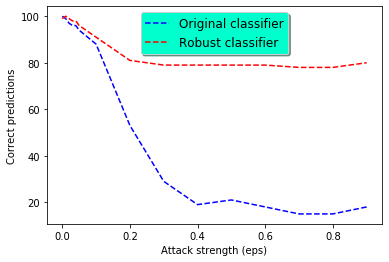

In [16]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(nb_correct_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Correct predictions')
plt.show()